
(ipykernel_launcher.py:206036): Gtk-WARNING **: 00:03:02.245: Locale not supported by C library.
	Using the fallback 'C' locale.


nodes:  50 links  69


/home/huang/anaconda3/envs/gt/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Generation 0: Min Fitness 3942.264854863829
Generation 1: Min Fitness 3942.264854863829
Generation 2: Min Fitness 3864.2327559687974
Generation 3: Min Fitness 3732.53411625914
Generation 4: Min Fitness 3732.53411625914
Generation 5: Min Fitness 3652.3444243247077
Generation 6: Min Fitness 3707.7464595777046
Generation 7: Min Fitness 3707.7464595777046
Generation 8: Min Fitness 3707.7464595777046
Generation 9: Min Fitness 3674.2595749213965
Generation 10: Min Fitness 3622.3261629921135
Generation 11: Min Fitness 3563.4905917502438
Generation 12: Min Fitness 3563.4905917502438
Generation 13: Min Fitness 3563.4905917502438
Generation 14: Min Fitness 3563.4905917502438
Generation 15: Min Fitness 3563.4905917502438
Generation 16: Min Fitness 3540.031213685934
Generation 17: Min Fitness 3540.031213685934
Generation 18: Min Fitness 3380.9236846034005
Generation 19: Min Fitness 3380.717608405841
Generation 0: Min Fitness 4512.704401796121
Generation 1: Min Fitness 4512.704401796121
Generation 

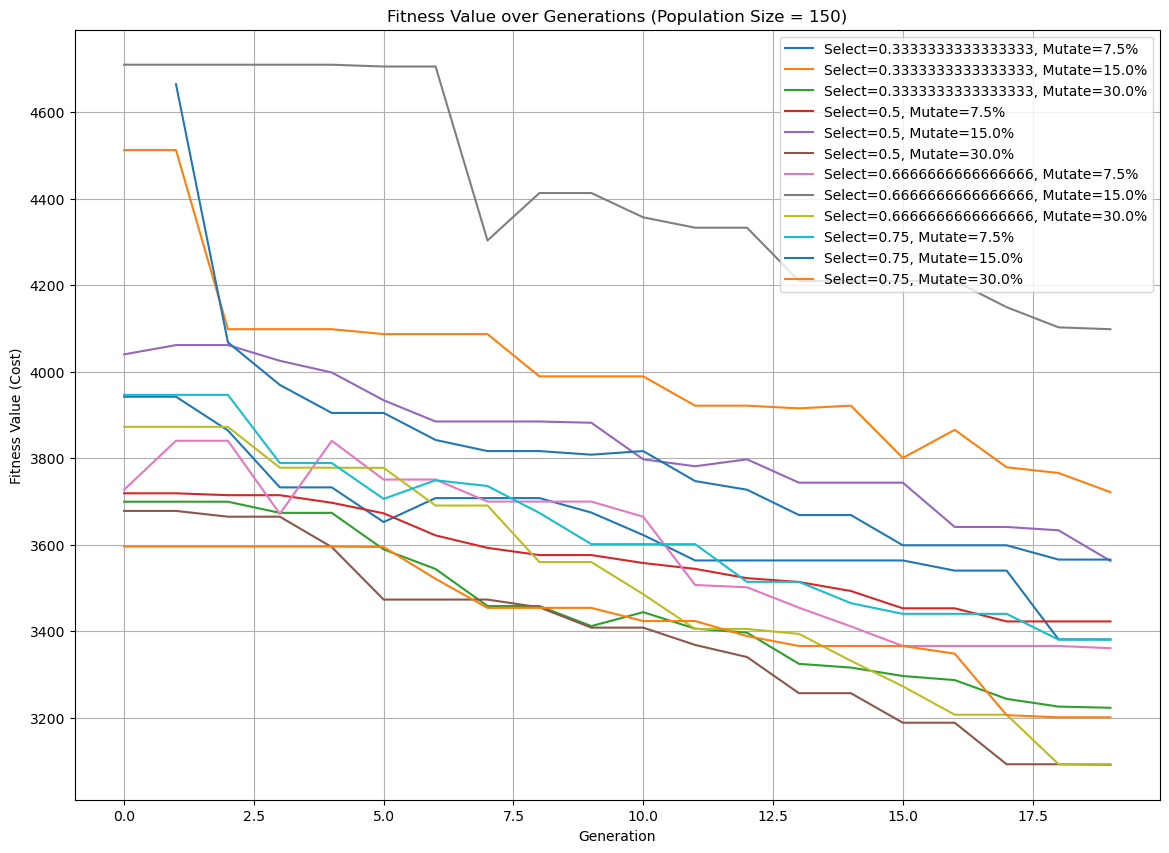

Generation 0: Min Fitness 3998.216013396982
Generation 1: Min Fitness 3998.216013396982
Generation 2: Min Fitness 3998.216013396982
Generation 3: Min Fitness 3614.122124863209
Generation 4: Min Fitness 3614.122124863209
Generation 5: Min Fitness 3586.3567243213556
Generation 6: Min Fitness 3584.100711321849
Generation 7: Min Fitness 3584.100711321849
Generation 8: Min Fitness 3584.100711321849
Generation 9: Min Fitness 3571.91790091473
Generation 10: Min Fitness 3465.2968407367753
Generation 11: Min Fitness 3464.742202410885
Generation 12: Min Fitness 3424.7017815798845
Generation 13: Min Fitness 3425.6867240241427
Generation 14: Min Fitness 3350.382733745179
Generation 15: Min Fitness 3311.9060760953344
Generation 16: Min Fitness 3241.43939741528
Generation 17: Min Fitness 3241.43939741528
Generation 18: Min Fitness 3267.756831950317
Generation 19: Min Fitness 3215.3097627940733
Generation 0: Min Fitness 4560.065749542429
Generation 1: Min Fitness inf
Generation 2: Min Fitness 3579.55

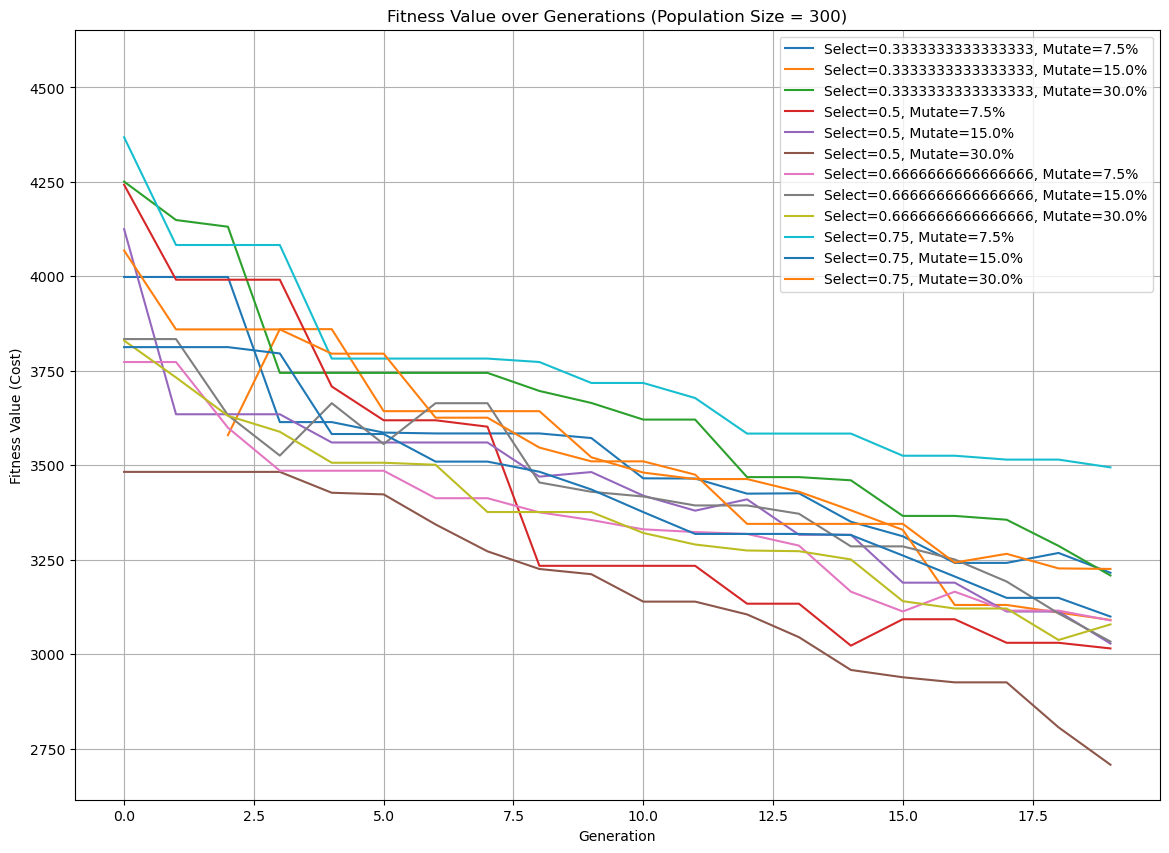

Generation 0: Min Fitness 3893.1908139278103
Generation 1: Min Fitness 3893.1908139278103
Generation 2: Min Fitness 3893.1908139278103
Generation 3: Min Fitness 3893.1908139278103
Generation 4: Min Fitness 3893.1908139278103
Generation 5: Min Fitness 3676.070984916312
Generation 6: Min Fitness 3706.538935902193
Generation 7: Min Fitness 3677.040521247649
Generation 8: Min Fitness 3607.4423885489505
Generation 9: Min Fitness 3597.7589927643535
Generation 10: Min Fitness 3470.487785089606
Generation 11: Min Fitness 3372.203102936051
Generation 12: Min Fitness 3372.203102936051
Generation 13: Min Fitness 3372.203102936051
Generation 14: Min Fitness 3379.622322879325
Generation 15: Min Fitness 3351.249865422174
Generation 16: Min Fitness 3306.552669915286
Generation 17: Min Fitness 3257.890241612745
Generation 18: Min Fitness 3166.8225697489015
Generation 19: Min Fitness 3122.426984151748
Generation 0: Min Fitness 3774.4343342270345
Generation 1: Min Fitness 3774.4343342270345
Generation 2

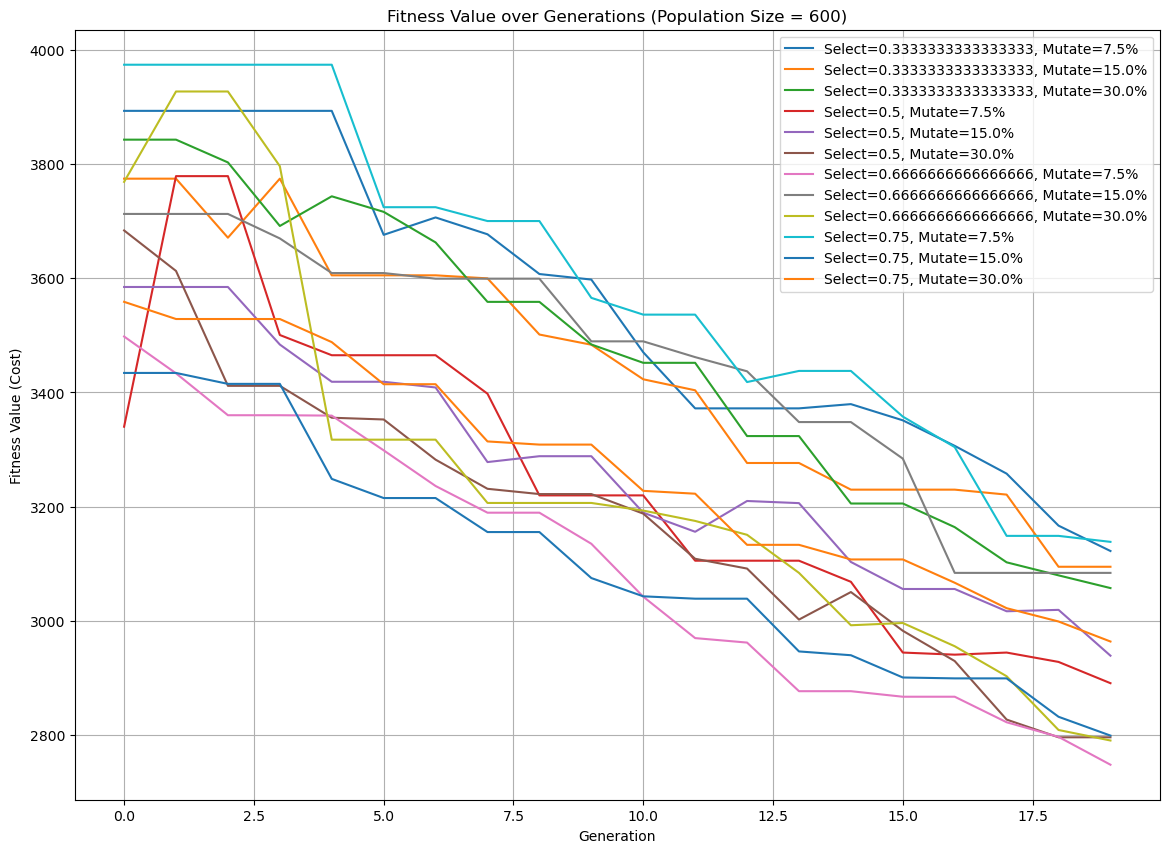

In [1]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights

# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,

# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2

# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数为文件中的边数量　初期個体を初期化する際にエッジ数をファイル中のエッジ数に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], num_edges)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)

# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main(population_size, selection_ratio, mutpb):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 20
    cxpb = 0.5  # 交叉概率

    # 初始化种群
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

        # 更新Hall of Fame
        hof.update(pop)

    return logbook, hof

# 配置参数
population_sizes = [150, 300, 600]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.075, 0.15, 0.3]

# 逐个运行并绘制图表
for population_size in population_sizes:
    logbooks = []
    labels = []

    for selection_ratio in selection_ratios:
        for mutpb in mutation_probs:
            logbook, _ = main(population_size, selection_ratio, mutpb)
            logbooks.append(logbook)
            labels.append(f'Select={selection_ratio}, Mutate={mutpb*100}%')

    # 绘制适应度值随迭代次数变化的图表
    plt.figure(figsize=(14, 10))

    for logbook, label in zip(logbooks, labels):
        min_fitness_values = logbook.select("min")
        plt.plot(range(len(min_fitness_values)), min_fitness_values, label=label)

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 保存图表
    plt.savefig(f"./output_36/fitness_over_generations_population_{population_size}.png")
    plt.show()


nodes:  50 links  69


/home/huang/anaconda3/envs/gt/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/huang/anaconda3/envs/gt/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: Min Fitness 3773.7863411018134
Generation 1: Min Fitness 3773.7863411018134
Generation 2: Min Fitness 3773.7863411018134
Generation 3: Min Fitness 3773.7863411018134
Generation 4: Min Fitness 3773.7863411018134
Generation 5: Min Fitness 3718.0597874658633
Generation 6: Min Fitness 3729.3170836254303
Generation 7: Min Fitness 3729.3170836254303
Generation 8: Min Fitness 3728.2537551543483
Generation 9: Min Fitness 3729.3170836254303
Generation 10: Min Fitness 3715.953496649013
Generation 11: Min Fitness 3686.6428784939526
Generation 12: Min Fitness 3596.674632982541
Generation 13: Min Fitness 3596.974071196634
Generation 14: Min Fitness 3596.974071196634
Generation 0: Min Fitness 3773.7863411018134
Generation 1: Min Fitness 3773.7863411018134
Generation 2: Min Fitness 3773.7863411018134
Generation 3: Min Fitness 4061.318472065923
Generation 4: Min Fitness 4061.318472065923
Generation 5: Min Fitness 4061.318472065923
Generation 6: Min Fitness 3825.9588296073234
Generation 7

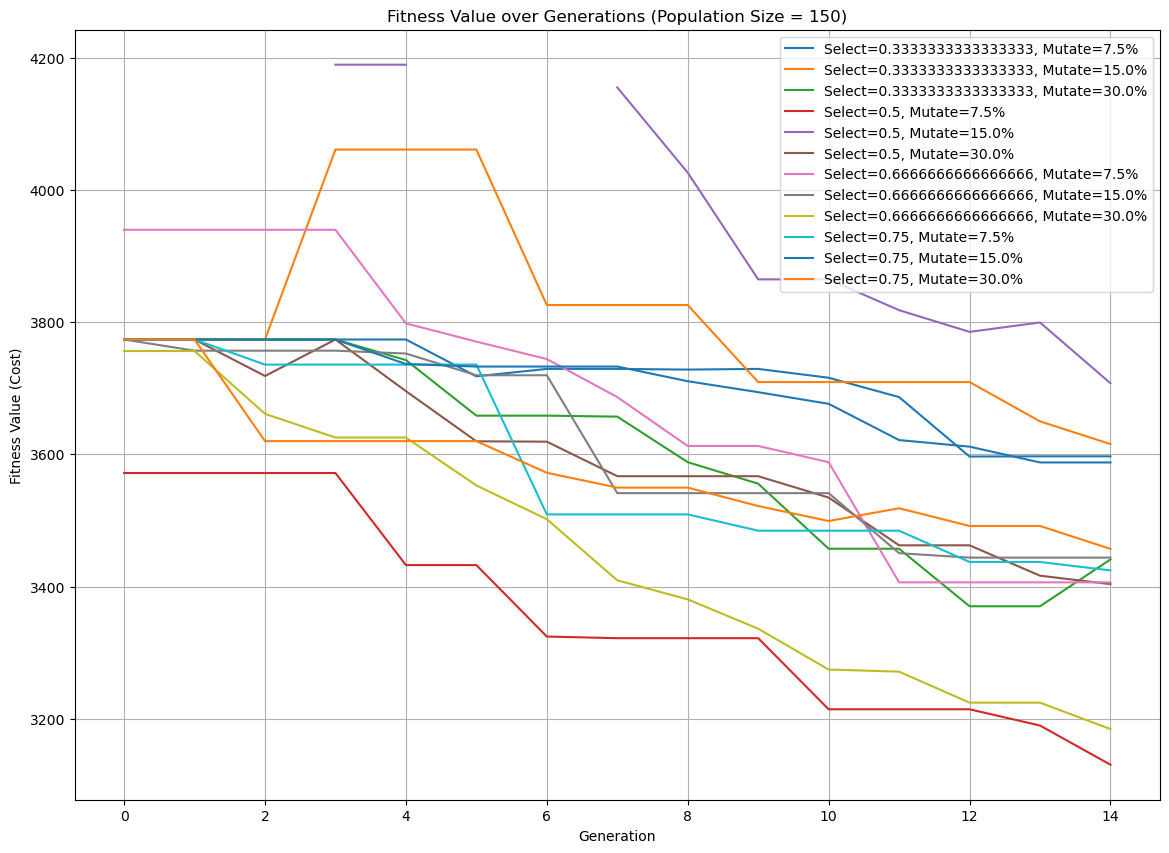

Generation 0: Min Fitness 3842.6565482411324
Generation 1: Min Fitness 3842.6565482411324
Generation 2: Min Fitness 3818.3813621037407
Generation 3: Min Fitness 3782.7408532412314
Generation 4: Min Fitness 3724.495310281155
Generation 5: Min Fitness 3724.495310281155
Generation 6: Min Fitness 3698.926854528011
Generation 7: Min Fitness 3546.499469664551
Generation 8: Min Fitness 3437.32440657236
Generation 9: Min Fitness 3437.32440657236
Generation 10: Min Fitness 3437.32440657236
Generation 11: Min Fitness 3412.9287022153185
Generation 12: Min Fitness 3386.0310329595527
Generation 13: Min Fitness 3305.9261204517334
Generation 14: Min Fitness 3305.9261204517334
Generation 0: Min Fitness 3842.6565482411324
Generation 1: Min Fitness 3769.6433875521934
Generation 2: Min Fitness 3769.6433875521934
Generation 3: Min Fitness 3700.3957275312223
Generation 4: Min Fitness 3708.12654517976
Generation 5: Min Fitness 3668.84702221694
Generation 6: Min Fitness 3668.84702221694
Generation 7: Min Fit

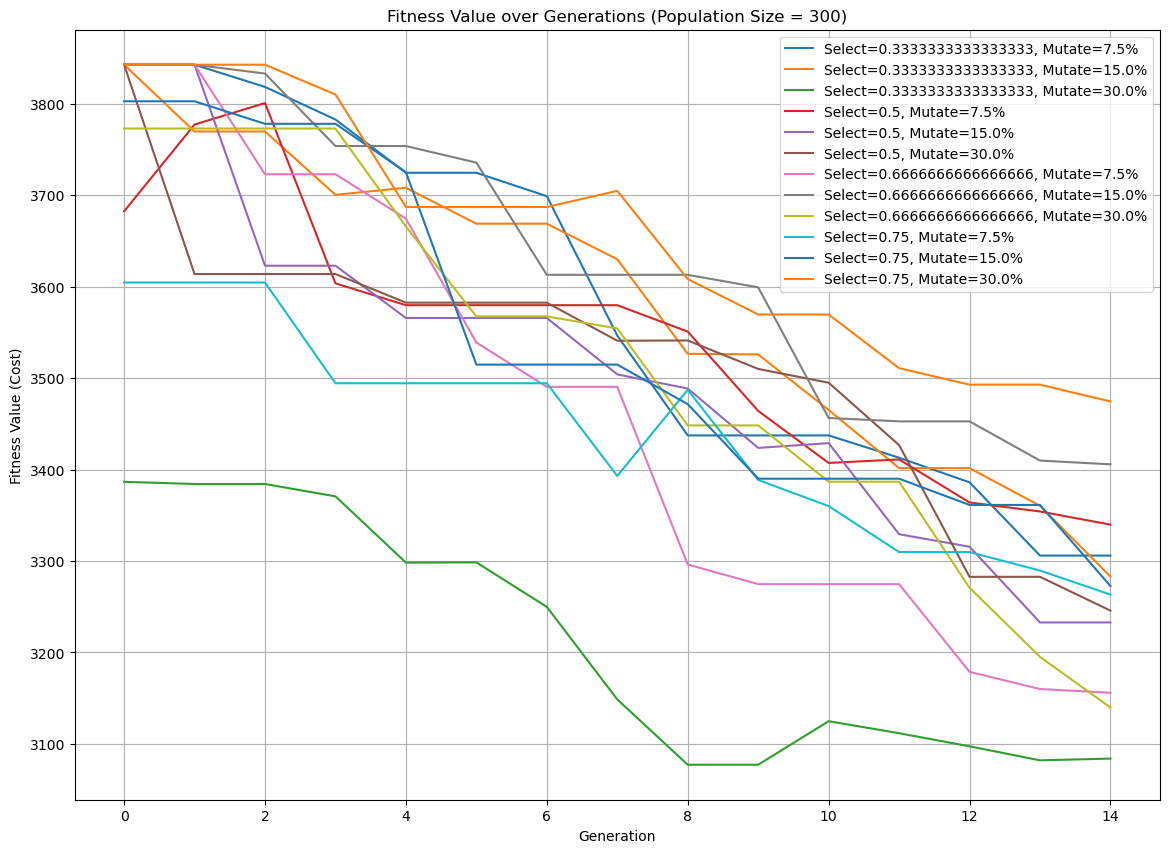

Generation 0: Min Fitness 3975.233048689796
Generation 1: Min Fitness 3867.5828837988956
Generation 2: Min Fitness 3867.5828837988956
Generation 3: Min Fitness 3867.5828837988956
Generation 4: Min Fitness 3597.4564992285273
Generation 5: Min Fitness 3525.3868888182215
Generation 6: Min Fitness 3525.3868888182215
Generation 7: Min Fitness 3525.3868888182215
Generation 8: Min Fitness 3388.000577257039
Generation 9: Min Fitness 3388.000577257039
Generation 10: Min Fitness 3387.328259187278
Generation 11: Min Fitness 3285.3586108627437
Generation 12: Min Fitness 3285.3586108627437
Generation 13: Min Fitness 3258.0600859577776
Generation 14: Min Fitness 3051.4251670214044
Generation 0: Min Fitness 3572.5919610896563
Generation 1: Min Fitness 3572.5919610896563
Generation 2: Min Fitness 3896.220417690958
Generation 3: Min Fitness 3891.7714427926912
Generation 4: Min Fitness 3716.6330644268783
Generation 5: Min Fitness 3646.7333035352212
Generation 6: Min Fitness 3646.7333035352212
Generation

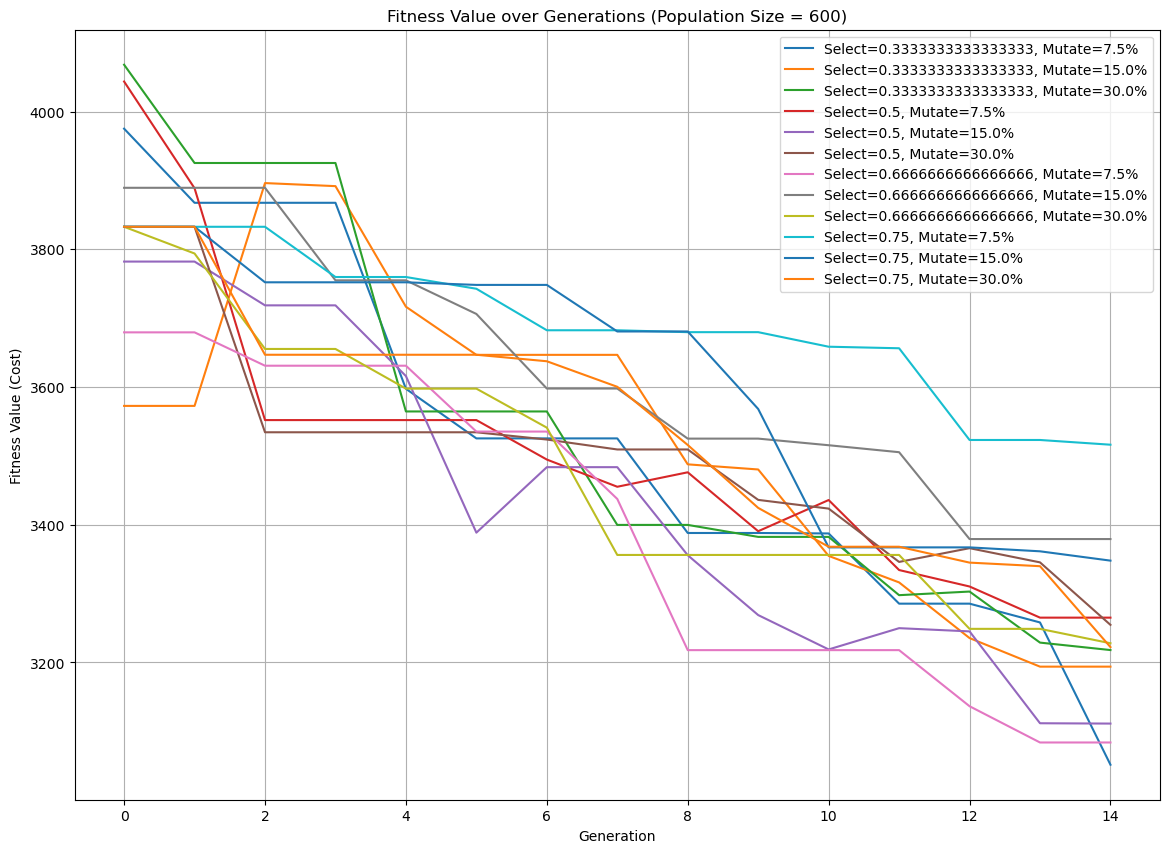

In [2]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights

# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,

# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2

# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数为文件中的边数量　初期個体を初期化する際にエッジ数をファイル中のエッジ数に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], num_edges)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)

# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main(initial_population, selection_ratio, mutpb):
    population_size = len(initial_population)
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 15
    cxpb = 0.5  # 交叉概率

    # 使用相同的初始种群
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

        # 更新Hall of Fame
        hof.update(pop)

    return logbook, hof

# 配置参数
population_sizes = [150, 300, 600]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.075, 0.15, 0.3]

# 生成固定的初始种群
initial_populations = {size: toolbox.population(n=size) for size in population_sizes}

# 逐个运行并绘制图表
for population_size in population_sizes:
    logbooks = []
    labels = []

    for selection_ratio in selection_ratios:
        for mutpb in mutation_probs:
            logbook, _ = main(initial_populations[population_size], selection_ratio, mutpb)
            logbooks.append(logbook)
            labels.append(f'Select={selection_ratio}, Mutate={mutpb*100}%')

    # 绘制适应度值随迭代次数变化的图表
    plt.figure(figsize=(14, 10))

    for logbook, label in zip(logbooks, labels):
        min_fitness_values = logbook.select("min")
        plt.plot(range(len(min_fitness_values)), min_fitness_values, label=label)

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 保存图表
    plt.savefig(f"./output_36/2fitness_over_generations_population_{population_size}.png")
    plt.show()


nodes:  50 links  69
Generation 0: Min Fitness 3791.153278503382
Generation 1: Min Fitness 3791.153278503382
Generation 2: Min Fitness 3634.7947265274547
Generation 3: Min Fitness 3542.8948640000763
Generation 4: Min Fitness 3634.7947265274547
Generation 5: Min Fitness 3634.7947265274547
Generation 6: Min Fitness 3619.45471999289
Generation 7: Min Fitness 3548.0454751746247
Generation 8: Min Fitness 3548.0454751746247
Generation 9: Min Fitness 3548.0454751746247
Generation 10: Min Fitness 3416.2281849626133
Generation 11: Min Fitness 3416.2281849626133
Generation 12: Min Fitness 3271.3982046493857
Generation 13: Min Fitness 3416.2281849626133
Generation 14: Min Fitness 3358.564671959993
Generation 15: Min Fitness 3358.564671959993
Generation 16: Min Fitness 3358.564671959993
Generation 17: Min Fitness 3332.0198724858246
Generation 18: Min Fitness 3332.0198724858246
Generation 19: Min Fitness 3332.0198724858246
Generation 20: Min Fitness 3310.4505961231544
Generation 21: Min Fitness 329

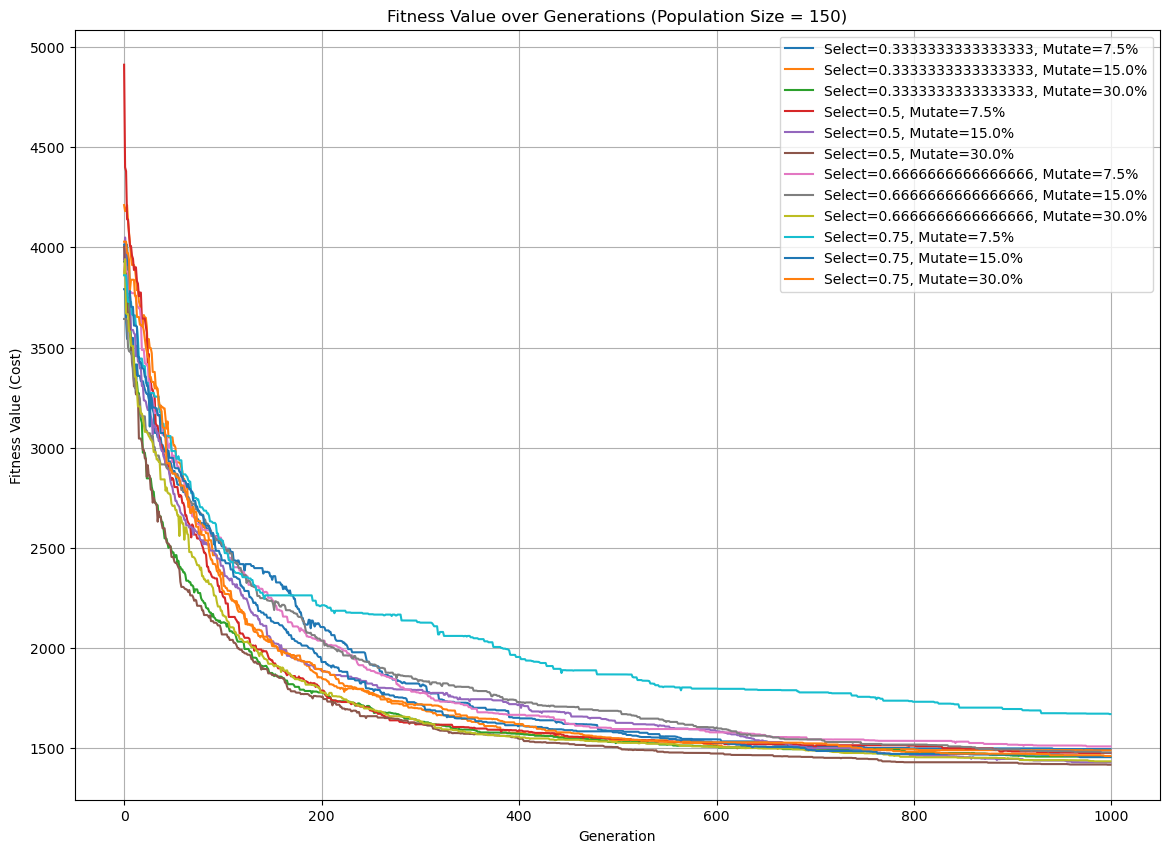

Generation 0: Min Fitness 3690.287703455934
Generation 1: Min Fitness 3690.287703455934
Generation 2: Min Fitness 3465.184575327913
Generation 3: Min Fitness 3465.184575327913
Generation 4: Min Fitness 3465.184575327913
Generation 5: Min Fitness 3421.3319154366077
Generation 6: Min Fitness 3421.3319154366077
Generation 7: Min Fitness 3421.3319154366077
Generation 8: Min Fitness 3396.616246406948
Generation 9: Min Fitness 3396.616246406948
Generation 10: Min Fitness 3383.9065965013597
Generation 11: Min Fitness 3281.634776295293
Generation 12: Min Fitness 3281.634776295293
Generation 13: Min Fitness 3281.634776295293
Generation 14: Min Fitness 3250.2574278434413
Generation 15: Min Fitness 3225.2758478151745
Generation 16: Min Fitness 3203.083551268971
Generation 17: Min Fitness 3191.6310575092334
Generation 18: Min Fitness 3170.5793873314806
Generation 19: Min Fitness 3133.10221496538
Generation 20: Min Fitness 3116.2164488497096
Generation 21: Min Fitness 3116.2164488497096
Generation 

KeyboardInterrupt: 

In [8]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights

# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,

# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2

# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数为文件中的边数量　初期個体を初期化する際にエッジ数をファイル中のエッジ数に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], num_edges)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)

# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main(population_size, selection_ratio, mutpb):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 1000
    cxpb = 0.5  # 交叉概率

    # 初始化种群
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

        # 更新Hall of Fame
        hof.update(pop)

    return logbook, hof

# 配置参数
population_sizes = [150, 300, 600]
selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
mutation_probs = [0.075, 0.15, 0.3]

# 逐个运行并绘制图表
for population_size in population_sizes:
    logbooks = []
    labels = []

    for selection_ratio in selection_ratios:
        for mutpb in mutation_probs:
            logbook, _ = main(population_size, selection_ratio, mutpb)
            logbooks.append(logbook)
            labels.append(f'Select={selection_ratio}, Mutate={mutpb*100}%')

    # 绘制适应度值随迭代次数变化的图表
    plt.figure(figsize=(14, 10))

    for logbook, label in zip(logbooks, labels):
        min_fitness_values = logbook.select("min")
        plt.plot(range(len(min_fitness_values)), min_fitness_values, label=label)

    plt.title(f"Fitness Value over Generations (Population Size = {population_size})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 保存图表
    plt.savefig(f"./output_36/fitness_over_generations_population_{population_size}.png")
    plt.show()
